# Assignment 4
Training a simple neural net for relation classification.

In [1]:
import torch
import torch.nn as nn
!pip install transformers

     |████████████████████████████████| 2.5MB 9.6MB/s 
     |████████████████████████████████| 3.3MB 47.4MB/s 
     |████████████████████████████████| 901kB 50.0MB/s 


In this assignment you are required to build a full training and testing pipeline for a neural relation classification (RC), using BERT.

The dataset that you will be working on is called SemEval Task 8 dataset (https://arxiv.org/pdf/1911.10422v1.pdf). The dataset contain only train and test split, but you are allowed to split the train dataset into dev if needed.


The two files (train and test) are available from the course git repository (https://github.com/kfirbar/nlp-course)


In this work we will use the hugingface framework for transformers training and inference. We recomand reading the documentation in https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification *before* you start coding. 


**Task 1:** Write a funtion *read_data* for reading the data from a single file (either train or test). This function recieves a filepath and returns a list of sentence. Every sentence is encoded as a touple, where the first element is the sentence string and the second the label (also represented as a sting). 

In [6]:
!git clone https://github.com/kfirbar/nlp-course

Cloning into 'nlp-course'...
remote: Enumerating objects: 71, done.
remote: Counting objects: 100% (71/71), done.
remote: Compressing objects: 100% (57/57), done.
remote: Total 71 (delta 29), reused 40 (delta 11), pack-reused 0
Unpacking objects: 100% (71/71), done.


In [17]:
FIRST_ENTITY_START_TOKEN = '<e1>'
SECOND_ENTITY_START_TOKEN = '<e2>'
entities_tags = [FIRST_ENTITY_START_TOKEN, '</e1>', SECOND_ENTITY_START_TOKEN, '</e2>']

In [8]:

def read_data(filepath):
    data = []
    # TODO... write your code accordingly

    with open(filepath) as f:
        while True:         
            sentense = next(f, None)
            if sentense is None:
                break

            label = next(f)
            _ = next(f)
            _ = next(f)
            data.append((sentense.strip(), label.strip()))

    return data


train = read_data('/content/nlp-course/TRAIN_FILE.TXT')
#test = read_data('/content/nlp-course/TEST_FILE.txt')


Pytorch require the labels to be integers. Create a mapper (dictionary) from the string labels to integers (starting zero). 

In [9]:
def create_label_mapper(data):
  # TODO... write your code accordingly 
  label_mapper = {}
  for _, label in data:
    if label not in label_mapper:
      label_mapper[label] = len(label_mapper)

  return label_mapper
  

label_mapper = create_label_mapper(train)
            

In [10]:
len(label_mapper), len(train)

(19, 8000)

**Task 2:** Write a function *prepare_data* that takes one of the [train, test] datasets and convert each pair of (words,labels) to a pair of indexes. The function also aggregate the samples into batches. BERT Uses pretrained tokanization and embedding. you can access the tokanization and indexing using the BertTokenizer class.

In [11]:
from transformers import BertTokenizer
import numpy as np

def prepare_data(data, tokenizer, batch_size=8, remove_entities_tags = False):
    data_sequences = []
    # TODO - your code...

    indexes = np.random.choice(range(0, len(data)), size = len(data) ,replace=False)
    
    current_batch_input = []
    current_batch_labels = []
    
    for i in range(0, len(indexes), batch_size): #index in indexes:
      curremt_indexes = indexes[i: i+ batch_size]
      batch_data = [data[i] for i in curremt_indexes]
      
      sentenses = [row[0] for row in batch_data]

      if remove_entities_tags:
        for entity_tag in entities_tags:
          sentenses = [sentense.replace(entity_tag, '') for sentense in sentenses]

      labels = torch.from_numpy(np.array([label_mapper[row[1]] for row in batch_data]))
      
      sentenses_ids = tokenizer.batch_encode_plus(sentenses, padding = 'longest', return_tensors='pt')['input_ids']
      
      data_sequences.append((sentenses_ids, labels))
    
    return data_sequences


tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', padding = 'max_length', truncation=True, return_tensors='pt')

train_sequences = prepare_data(train, tokenizer, remove_entities_tags=True)

# test_sequences = prepare_data(test, tokenizer)

In [13]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

**Task 3:** In this part we classify the sentences using the BertForSequenceClassification model. To save resources, we initialize the optimizer with the final layer of the model. You are also allowed to change the learning rate.

In [14]:
from transformers import BertForSequenceClassification

def get_parameters(params):
  # TODO - your code...
  fixed_params = []
  for name, param in params:
    if 'classifier' not in name:
      param.requires_grad = False
    fixed_params.append(param)

  return fixed_params

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_mapper)).to(device)

# Optimizer (ADAM is a fancy version of SGD)
optimizer = torch.optim.Adam(get_parameters(model.named_parameters()), lr=0.001)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

**Task 4:** Write a training loop, which takes a BertForSequenceClassification model and number of epochs to train on. The loss is always CrossEntropyLoss and the optimizer is always Adam. You are allowed to split the train to train and dev sets.

In [ ]:
from torch.autograd import Variable

def train_loop(model, n_epochs, train_data, dev_data):
  # Loss function
  model.train()
  criterion = nn.CrossEntropyLoss()
 
  for e in range(1, n_epochs + 1):
    batch_loss = 0.0 
    for sentenses, labels in train_data:
      sentenses = Variable(sentenses).to(device)
      labels = Variable(labels).to(device)

      logits = model(sentenses).logits
      loss = criterion(logits, labels)

      batch_loss += loss.item()

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
     
      
    
    print('batch {} loss {}'.format(e, batch_loss/len(train_data)))



train_loop(model,100, train_sequences, None)


batch 1 loss 2.7332123152017593
batch 2 loss 2.6692887511253356
batch 3 loss 2.6196994042396544
batch 4 loss 2.5933048094511033
batch 5 loss 2.5591999559402465
batch 6 loss 2.545403914690018
batch 7 loss 2.5247345197200777
batch 8 loss 2.497903301715851
batch 9 loss 2.489982751727104
batch 10 loss 2.489350494623184
batch 11 loss 2.4793478957414625
batch 12 loss 2.46604198551178
batch 13 loss 2.4546597558259964
batch 14 loss 2.442286616206169
batch 15 loss 2.443987538218498
batch 16 loss 2.432078175663948
batch 17 loss 2.429134279727936
batch 18 loss 2.429857209086418
batch 19 loss 2.427776198267937
batch 20 loss 2.4209993138313295
batch 21 loss 2.4211116232872008
batch 22 loss 2.4101237890720366
batch 23 loss 2.407373149394989


KeyboardInterrupt: ignored

**Task 5:** write an evaluation loop on a trained model, using the dev and test datasets. This function print the true positive rate (TPR), also known as Recall and the opposite to false positive rate (FPR), also known as precision, of each label seperately (10 labels in total), and for all labels together. The caption argument for the function should be served for printing, so that when you print include it as a prefix.

In [ ]:
from sklearn import metrics

def evaluate(model, test_data):
  # TODO - your code goes here
  model.eval()
  all_predictions = []
  all_labels = []
  with torch.no_grad():
    for sentenses, labels in test_data:
      sentenses = Variable(sentenses).to(device)
      labels = labels.numpy()

      logits = model(sentenses).logits

      prediction = torch.argmax(logits, 1).cpu().detach().numpy()

      all_labels.extend(labels.tolist())
      all_predictions.extend(prediction.tolist())

    print(metrics.classification_report(labels, prediction, digits=3))
      

evaluate(model, train_sequences)

              precision    recall  f1-score   support

           0      1.000     0.500     0.667         2
           1      0.000     0.000     0.000         0
           2      0.000     0.000     0.000         1
           4      0.000     0.000     0.000         0
           5      0.000     0.000     0.000         1
           6      0.000     0.000     0.000         1
           7      0.000     0.000     0.000         0
           9      0.000     0.000     0.000         1
          10      0.000     0.000     0.000         1
          12      1.000     1.000     1.000         1

    accuracy                          0.250         8
   macro avg      0.200     0.150     0.167         8
weighted avg      0.375     0.250     0.292         8



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Task 6:** In this part we'll improve the model accuracy by using a method called "entity markers - Entity start". The main idea of this approch is to add special markers ([e1], [\e1], ...) before and after each of the tagged entities. instead of using the CLS toekn for clasification, we will use the concatination of the embedding of [e1] and [e2] as shown in the image below. The complete method is described in details in the following paper - https://arxiv.org/pdf/1906.03158.pdf (specifically in Section 3.2). To use this method we'll need to create a new data load and a new model.

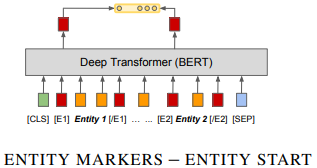

The new methods require the usage of special tokens. The following code will add the required tokens.

In [26]:
tokenizer.add_tokens(entities_tags)
first_entity_start_token_id, second_entity_start_token_id = tokenizer.convert_tokens_to_ids([FIRST_ENTITY_START_TOKEN, SECOND_ENTITY_START_TOKEN])
first_entity_start_token_id, second_entity_start_token_id


(30522, 30524)

Create a new dataloader that add entity markers to the dataset and return their indexes as part of the new sample (the expected sample should be (s, l, i) where s is the sentence embedding, l is the label, and i is a touple with the indexes of the start entities)

In [27]:
def prepare_data_MTB(data, tokenizer, batch_size=8):
    data_sequences = []
    # TODO - your code...

    indexes = np.random.choice(range(0, len(data)), size = len(data) ,replace=False)
    
    current_batch_input = []
    current_batch_labels = []
    
    for i in range(0, len(indexes), batch_size): #index in indexes:
      curremt_indexes = indexes[i: i+ batch_size]
      batch_data = [data[i] for i in curremt_indexes]
      
      sentenses = [row[0] for row in batch_data]

      labels = torch.from_numpy(np.array([label_mapper[row[1]] for row in batch_data]))
      
      sentenses_ids = tokenizer.batch_encode_plus(sentenses, padding = 'longest', return_tensors='pt')['input_ids']
      
      # print(sentenses_ids[0].numpy().tolist().index(102))
      # break 
      first_send_entites_start_locations = [(sentense_ids.numpy().tolist().index(first_entity_start_token_id), sentense_ids.numpy().tolist().index(second_entity_start_token_id)) for sentense_ids in sentenses_ids]

    #   data_sequences.append((sentenses_ids, labels, first_send_entites_start_locations))
    
    # return data_sequences


    return data_sequences

train_sequences = prepare_data_MTB(train, tokenizer)
#test_sequences = prepare_data_MTB(test, tokenizer)

Create a new model that uses the "entity markers - Entity start" method.

In [ ]:
from transformers import AutoConfig


class MTB(nn.Module):
    def __init__(self, base_model_name):
      nn.Module.__init__(self)
      config = AutoConfig.from_pretrained(base_model_name)
      self.model = AutoModel.from_config(config)
      # TODO - your code...
    def forward(self, input, index):
      # TODO - your code...
      pass


model = MTB('bert-base-uncased')

# config = AutoConfig.from_pretrained('bert-base-uncased')
# model1 = AutoModel.from_config(config)

Use the new dataloader and model to train and evaluate the new model as in task 4 and 5

In [ ]:
train_loop(model, n_epochs, train_data, dev_data)
evaluate(model, test_data)


**Good luck!**